In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

import warnings


In [3]:
data = pd.read_csv("h2o_exog.csv")

In [4]:
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d' )
data = data.set_index('date' )
data = data.asfreq('MS')
data = data.sort_index()
data.head()

y    exog_1    exog_2
date                                    
1992-04-01  0.379808  0.958792  1.166029
1992-05-01  0.361801  0.951993  1.117859
1992-06-01  0.410534  0.952955  1.067942
1992-07-01  0.483389  0.958078  1.097376
1992-08-01  0.475463  0.956370  1.122199

In [5]:
data.isnull().any(axis=1)

date
1992-04-01    False
1992-05-01    False
1992-06-01    False
1992-07-01    False
1992-08-01    False
              ...  
2008-02-01    False
2008-03-01    False
2008-04-01    False
2008-05-01    False
2008-06-01    False
Freq: MS, Length: 195, dtype: bool

In [6]:
data.isnull().any(axis=1).sum()

0

In [7]:
steps = 36
train_data = data[:-steps]
test_data = data[-steps:]

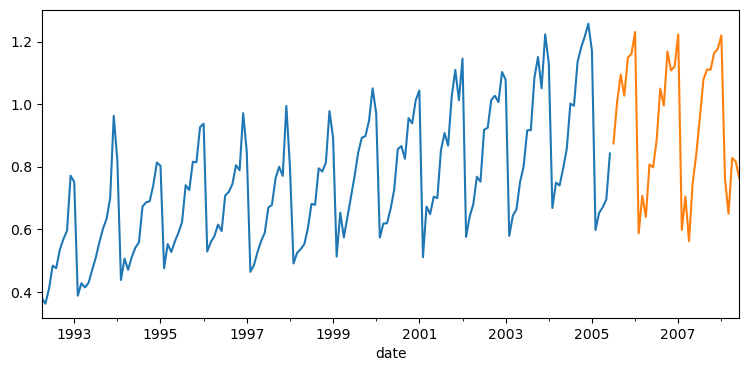

In [8]:
fig , ax = plt.subplots(figsize=(9,4))
train_data["y"].plot()
test_data["y"].plot()
plt.show()

In [9]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123),
    lags = 6
)
forecaster.fit(y=train_data["y"])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2025-02-11 11:08:59 
Last fit date: 2025-02-11 11:08:59 
Skforecast version: 0.7.0 
Python version: 3.11.7 
Forecaster id: None 

In [10]:
prediction = forecaster.predict(steps)
prediction.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

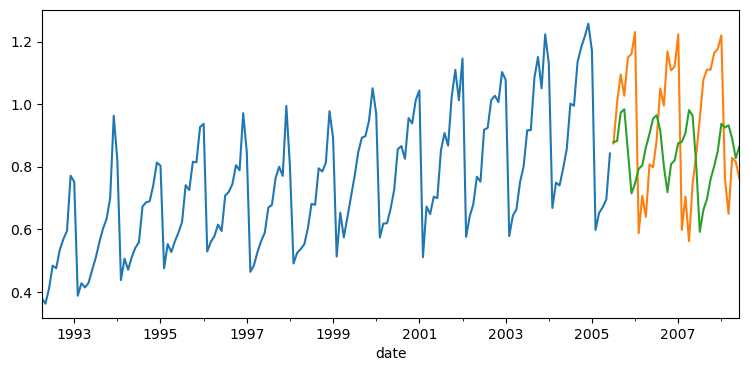

In [11]:
fig , ax = plt.subplots(figsize=(9,4))
train_data["y"].plot()
test_data["y"].plot()
prediction.plot()
plt.show()

In [12]:
error_mse = mean_squared_error(
    y_true = test_data["y"],
    y_pred = prediction
)
print(error_mse)

0.07326833976120374


In [13]:
forecaster = ForecasterAutoreg(
    regressor = RandomForestRegressor(random_state=123),
    lags = 12
)
lags_grid=[10,15,20]
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = train_data["y"],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(train_data)*0.5),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 18.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:47<00:00, 15.78s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 0.012590983980173628



In [14]:
results_grid

lags  \
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
16  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
0                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
1                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
3                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
5                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
2                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
4                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   

                                    params  mean_squared_error  max_depth  \
8    {'max_depth': 5, 'n_estimators': 100}            0.012591          5   
7    {'max_depth': 3, 'n_estimators': 500}            0.012633          3   
6    {'max_depth': 3, 'n_estimators': 100}            0.012765          3   
13   {'max_depth': 3, 'n_estimators': 500}            0.012836          3   
12   {'max_depth': 3, 'n_estimators': 100}            0.012858          3   
11  {'max_depth': 10, 'n_estimators': 500}            0.013129         10   
9    {'max_depth': 5, 'n_estimators': 500}            0.013187          5   
15   {'max_depth': 5, 'n_estimators': 500}            0.013248          5   
14   {'max_depth': 5, 'n_estimators': 100}            0.013364          5   
17  {'max_depth': 10, 'n_estimators': 500}            0.013435         10   
10  {'max_depth': 10, 'n_estimators': 100}            0.013566         10   
16  {'max_depth': 10, 'n_estimators': 100}            0.014028         10   
0    {'max_depth': 3, 'n_estimators': 100}            0.036982          3   
1    {'max_depth': 3, 'n_estimators': 500}            0.037345          3   
3    {'max_depth': 5, 'n_estimators': 500}            0.037574          5   
5   {'max_depth': 10, 'n_estimators': 500}            0.040542         10   
2    {'max_depth': 5, 'n_estimators': 100}            0.041474          5   
4   {'max_depth': 10, 'n_estimators': 100}            0.047870         10   

    n_estimators  
8            100  
7            500  
6            100  
13           500  
12           100  
11           500  
9            500  
15           500  
14           100  
17           500  
10           100  
16           100  
0            100  
1            500  
3            500  
5            500  
2            100  
4            100

In [15]:
regressor = RandomForestRegressor(max_depth= 5, n_estimators= 100,random_state= 123)
forecaster = ForecasterAutoreg(
    regressor = regressor,
    lags= 20
)
forecaster.fit(y = train_data["y"])
prediction = forecaster.predict(steps=steps)

In [16]:
regressor = RandomForestRegressor(max_depth= 5, n_estimators= 100,random_state= 123)
forecaster2 = ForecasterAutoreg(
    regressor = regressor,
    lags= 15
)
forecaster2.fit(y = train_data["y"])
prediction2 = forecaster2.predict(steps=steps)

In [17]:
fig , ax = plt.subplots(figsize=(9,4))
train_data["y"].plot()
test_data["y"].plot()
prediction.plot()
prediction2.plot()
plt.show()

In [18]:
error_mse = mean_squared_error(
    y_true = test_data["y"],
    y_pred = prediction
)
error_mse2 = mean_squared_error(
    y_true = test_data["y"],
    y_pred = prediction2
)
print(error_mse)
print(error_mse2)

0.004478617116319261
0.004024596569903877


In [19]:
forecaster2.fit(y = data["y"])
prediction3 = forecaster2.predict(steps=steps)

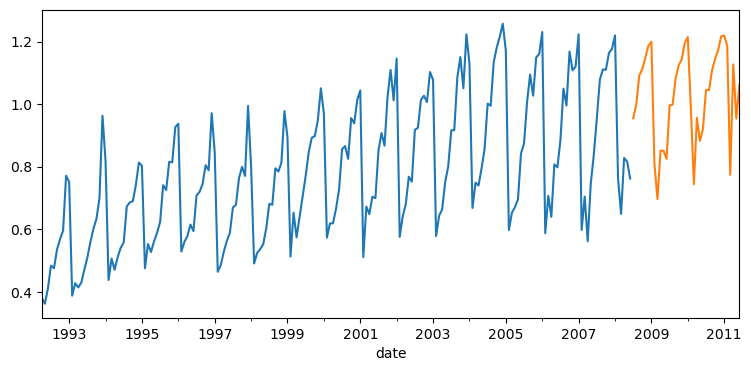

In [20]:
fig , ax = plt.subplots(figsize=(9,4))
data["y"].plot()
prediction3.plot()
plt.show()